# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Explaining-Decision-Trees-and-Random-Forests" data-toc-modified-id="Explaining-Decision-Trees-and-Random-Forests-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Explaining Decision Trees and Random Forests</a></div><div class="lev1 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Create-Feature-Contribution" data-toc-modified-id="Create-Feature-Contribution-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Create Feature Contribution</a></div><div class="lev1 toc-item"><a href="#Visualizing-Decision-Trees" data-toc-modified-id="Visualizing-Decision-Trees-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualizing Decision Trees</a></div><div class="lev2 toc-item"><a href="#Regression" data-toc-modified-id="Regression-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Regression</a></div><div class="lev2 toc-item"><a href="#Binary-Classification" data-toc-modified-id="Binary-Classification-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Binary Classification</a></div><div class="lev2 toc-item"><a href="#Multinomial-Classification" data-toc-modified-id="Multinomial-Classification-53"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Multinomial Classification</a></div><div class="lev1 toc-item"><a href="#Plot-Feature-Importances" data-toc-modified-id="Plot-Feature-Importances-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot Feature Importances</a></div><div class="lev1 toc-item"><a href="#Plot-Feature-Contributions" data-toc-modified-id="Plot-Feature-Contributions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot Feature Contributions</a></div><div class="lev1 toc-item"><a href="#Plotting-Individual-Features" data-toc-modified-id="Plotting-Individual-Features-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Plotting Individual Features</a></div>

# Explaining Decision Trees and Random Forests

This notebook shows examples of how the `treeinterpreter` (<a href='https://github.com/andosa/treeinterpreter'>https://github.com/andosa/treeinterpreter</a>) library works and provides some insightful plots to gain a deeper understanding of what a decision tree or random forest is doing.

I have created a set of useful plotting functions in the file `tree_interp_functions.py`.

# Import Libraries

In [95]:
# -*- coding: utf-8 -*-

from __future__ import division

%matplotlib inline

%reload_ext autoreload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,\
                         export_graphviz
from treeinterpreter import treeinterpreter as ti
import pydotplus
from IPython.display import Image, display


from tree_interp_functions import *


In [96]:
# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set seaborn colours
sns.set_style('darkgrid')
sns.set_palette('colorblind')
print("before sns.color_palette()")

color_l = sns.color_palette('colorblind')
blue = color_l[0]
green = color_l[0]
red = color_l[0]
purple = color_l[0]
yellow = color_l[0]
cyan = color_l[0]

before sns.color_palette()


# Load Data
We will use the abalone data set as an example. We would like to show how this works for decision tree and random forest regressors as well as classifiers. We use the `rings` variable as our continuous variable and create a binary variable from it to indicate whether `rings > 9`.

In [97]:
column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
abalone_df = pd.read_csv('abalone.csv', names=column_names) #hz- 来自当前文件下的abalone.csv
abalone_df['sex'] = abalone_df['sex'].map({'F': 0, 'M': 1, 'I': 2})
abalone_df['y'] = abalone_df.rings.map(lambda x: 1 if x > 9 else 0)
abalone_df.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,y
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


Here, we do a simple train/test split of the data.

In [98]:
abalone_train, abalone_test = train_test_split(abalone_df, test_size=0.2,
                                               random_state=0)

X_train = abalone_train.drop(['sex', 'rings', 'y'], axis=1)
y_train_bin_clf = abalone_train.y
y_train_multi_clf = abalone_train.sex
y_train_reg = abalone_train.rings

X_test = abalone_test.drop(['sex', 'rings', 'y'], axis=1)
y_test_bin_clf = abalone_test.y
y_test_multi_clf = abalone_test.sex
y_test_reg = abalone_test.rings

X_train = X_train.copy().reset_index(drop=True)
y_train_bin_clf = y_train_bin_clf.copy().reset_index(drop=True)
y_train_multi_clf = y_train_multi_clf.copy().reset_index(drop=True)
y_train_reg = y_train_reg.copy().reset_index(drop=True)
X_test = X_test.copy().reset_index(drop=True)
y_test_bin_clf = y_test_bin_clf.copy().reset_index(drop=True)
y_test_multi_clf = y_test_multi_clf.copy().reset_index(drop=True)
y_test_reg = y_test_reg.copy().reset_index(drop=True)

In [99]:
abalone_train.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,y
3141,2,0.180,0.135,0.080,0.0330,0.0145,0.0070,0.0100,5,0
3521,2,0.215,0.150,0.055,0.0410,0.0150,0.0090,0.0125,3,0
883,1,0.660,0.530,0.170,1.3905,0.5905,0.2120,0.4530,15,1
3627,1,0.715,0.525,0.200,1.8900,0.9500,0.4360,0.4305,10,1
2106,1,0.595,0.455,0.155,1.0410,0.4160,0.2105,0.3650,14,1


# Build Model
Now, we build simple decision tree and random forest models. We will limit the depth of the decision tree to show how the interpretation works.

In [100]:
dt_bin_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                    random_state=0)
dt_bin_clf.fit(X_train, y_train_bin_clf)

dt_multi_clf = DecisionTreeClassifier(criterion='entropy', max_depth=2,
                                      random_state=0)
dt_multi_clf.fit(X_train, y_train_multi_clf)

dt_reg = DecisionTreeRegressor(criterion='mse', max_depth=3,
                               random_state=0)
dt_reg.fit(X_train, y_train_reg)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [101]:
rf_bin_clf = RandomForestClassifier(criterion='entropy', max_depth=10,
                                    n_estimators=100, random_state=0) #hz-
rf_bin_clf.fit(X_train, y_train_bin_clf)
print("np.shape(X_train): "+str(  np.shape(X_train)  ))
print("np.shape(y_train_bin_clf): "+str(  np.shape(y_train_bin_clf)  ))

rf_multi_clf = RandomForestClassifier(criterion='entropy', max_depth=10,
                                      n_estimators=100, random_state=0)
rf_multi_clf.fit(X_train, y_train_multi_clf)

rf_reg = RandomForestRegressor(criterion='mse', max_depth=10,
                               n_estimators=100, random_state=0)
rf_reg.fit(X_train, y_train_reg)

np.shape(X_train): (3341, 7)
np.shape(y_train_bin_clf): (3341,)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

## Create Feature Contribution
We use the `ti.predict` function to get our predictions, biases, and contributions. The contributions matrix is a 3d array which represents the contribution for each example, feature, and class label.

In [102]:
dt_bin_clf_pred, dt_bin_clf_bias, dt_bin_clf_contrib = ti.predict(dt_bin_clf, X_test)
rf_bin_clf_pred, rf_bin_clf_bias, rf_bin_clf_contrib = ti.predict(rf_bin_clf, X_test) #hz-
print("np.shape(rf_bin_clf_contrib): "+str( np.shape(rf_bin_clf_contrib)  ))
print("rf_bin_clf_contrib          : "+str( rf_bin_clf_contrib  ))

dt_multi_clf_pred, dt_multi_clf_bias, dt_multi_clf_contrib = ti.predict(dt_multi_clf, X_test)
rf_multi_clf_pred, rf_multi_clf_bias, rf_multi_clf_contrib = ti.predict(rf_multi_clf, X_test)

dt_reg_pred, dt_reg_bias, dt_reg_contrib = ti.predict(dt_reg, X_test)
rf_reg_pred, rf_reg_bias, rf_reg_contrib = ti.predict(rf_reg, X_test)
print("rf_reg_pred"+str(rf_reg_pred))

np.shape(rf_bin_clf_contrib): (836, 7, 2)
rf_bin_clf_contrib          : [[[-0.02004618  0.02004618]
  [-0.02098924  0.02098924]
  [-0.01213192  0.01213192]
  ...
  [-0.13360526  0.13360526]
  [-0.04504895  0.04504895]
  [-0.14803709  0.14803709]]

 [[-0.01645077  0.01645077]
  [-0.03088857  0.03088857]
  [ 0.09845064 -0.09845064]
  ...
  [-0.06475589  0.06475589]
  [-0.0123882   0.0123882 ]
  [-0.04407044  0.04407044]]

 [[-0.02329103  0.02329103]
  [ 0.00680496 -0.00680496]
  [-0.0227528   0.0227528 ]
  ...
  [ 0.0172213  -0.0172213 ]
  [-0.03521496  0.03521496]
  [-0.11093141  0.11093141]]

 ...

 [[ 0.0098203  -0.0098203 ]
  [-0.01025082  0.01025082]
  [ 0.11349476 -0.11349476]
  ...
  [-0.03914917  0.03914917]
  [ 0.07007241 -0.07007241]
  [ 0.14379034 -0.14379034]]

 [[-0.02051074  0.02051074]
  [ 0.00267973 -0.00267973]
  [-0.11107975  0.11107975]
  ...
  [-0.07900824  0.07900824]
  [-0.00327424  0.00327424]
  [-0.13806068  0.13806068]]

 [[ 0.0281926  -0.0281926 ]
  [ 0.06755975

# Visualizing Decision Trees
We can visualize a decision tree by using graphviz. This will show every path down to the leaves and the proportion of the two classes in each node.

## Regression

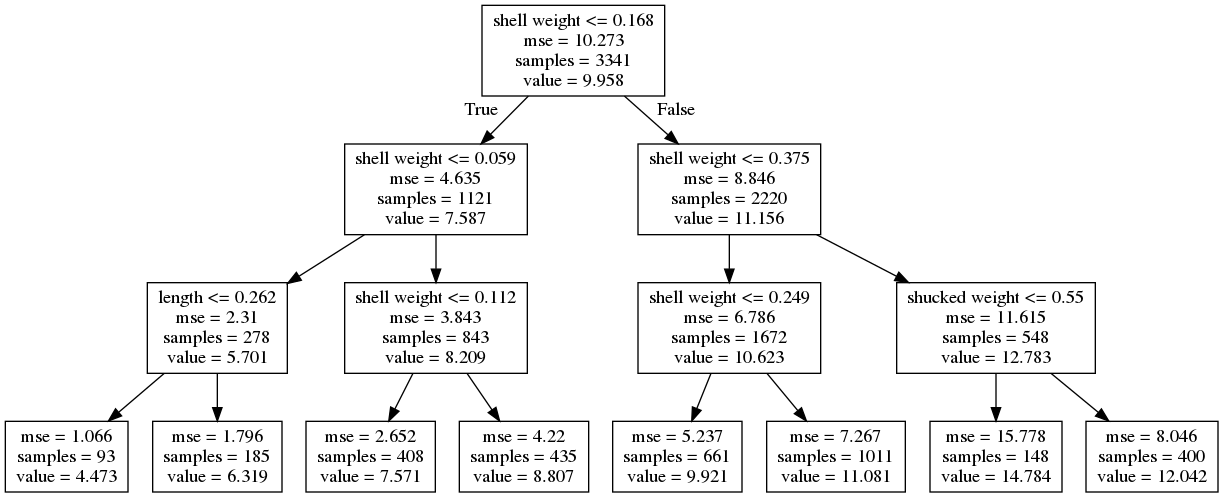

In [103]:
reg_dot_data = export_graphviz(dt_reg,
                               out_file=None,
                               feature_names=X_train.columns
                              )
reg_graph = pydotplus.graph_from_dot_data(reg_dot_data)
Image(reg_graph.create_png())

## Binary Classification

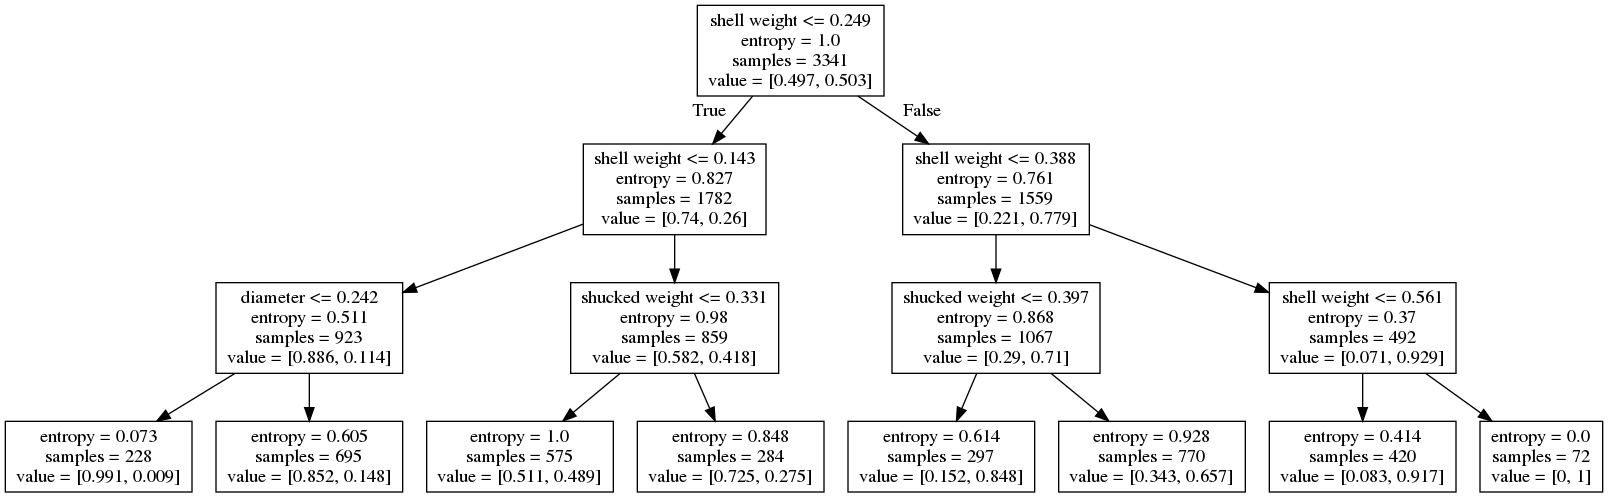

In [104]:
bin_clf_dot_data = export_graphviz(dt_bin_clf,
                                   out_file=None,
                                   feature_names=X_train.columns
                                  )
bin_clf_graph = pydotplus.graph_from_dot_data(bin_clf_dot_data)
Image(bin_clf_graph.create_png())

## Multinomial Classification

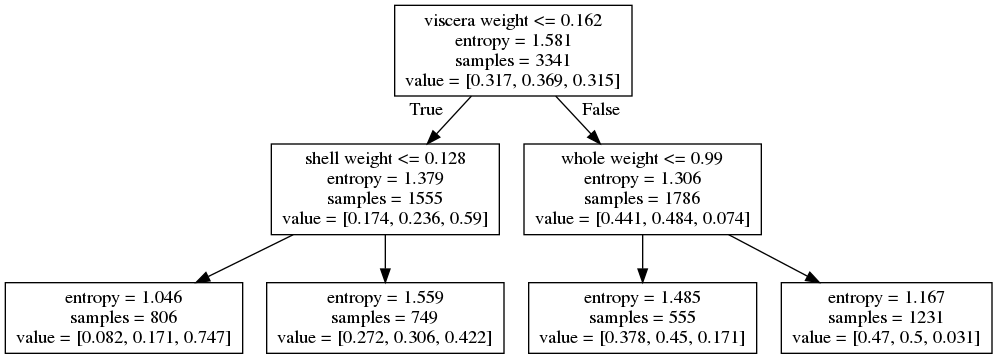

In [105]:
multi_clf_dot_data = export_graphviz(dt_multi_clf,
                                     out_file=None,
                                     feature_names=X_train.columns
                                    )
multi_clf_graph = pydotplus.graph_from_dot_data(multi_clf_dot_data)
Image(multi_clf_graph.create_png())

# Plot Feature Importances
Feature importances, which are built into sklearn, are a more standard way to understand decision trees and random forests. They describe how well a given feature splits the population. However, they do not give any insight into the directionality of the feature, i.e., how exactly it affects the response variable.

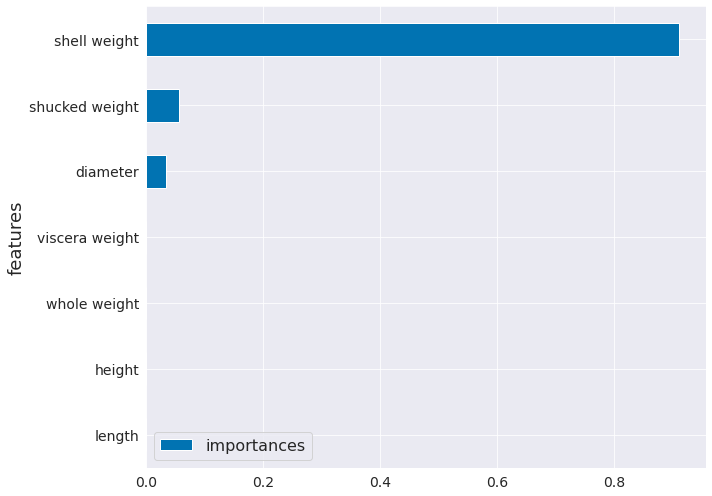

In [106]:
df_importances = pd.DataFrame({'features': X_train.columns,
                               'importances': dt_bin_clf.feature_importances_
                              })
df_importances\
    .set_index('features')\
    .sort_values('importances')\
    .plot(kind='barh')
plt.tight_layout()

# Plot Feature Contributions
We can use feature contributions to better understand decision trees and random forests. Unlike feature importances, feature contributions are not numbers representative of the entire data set, but for a single observation. More specifically, it depends on which leaf/leaves the observation falls into. We show feature contributions for two examples, where we order the features by their absolute contribution.

hz- np.shape(rf_bin_clf_contrib_: (836, 7, 2)
hz- np.shape(X_test): (836, 7)
hz- np.shape(y_test_bin_clf): (836,)
hz- rf_bin_clf_contrib: [[[-0.02004618  0.02004618]
  [-0.02098924  0.02098924]
  [-0.01213192  0.01213192]
  ...
  [-0.13360526  0.13360526]
  [-0.04504895  0.04504895]
  [-0.14803709  0.14803709]]

 [[-0.01645077  0.01645077]
  [-0.03088857  0.03088857]
  [ 0.09845064 -0.09845064]
  ...
  [-0.06475589  0.06475589]
  [-0.0123882   0.0123882 ]
  [-0.04407044  0.04407044]]

 [[-0.02329103  0.02329103]
  [ 0.00680496 -0.00680496]
  [-0.0227528   0.0227528 ]
  ...
  [ 0.0172213  -0.0172213 ]
  [-0.03521496  0.03521496]
  [-0.11093141  0.11093141]]

 ...

 [[ 0.0098203  -0.0098203 ]
  [-0.01025082  0.01025082]
  [ 0.11349476 -0.11349476]
  ...
  [-0.03914917  0.03914917]
  [ 0.07007241 -0.07007241]
  [ 0.14379034 -0.14379034]]

 [[-0.02051074  0.02051074]
  [ 0.00267973 -0.00267973]
  [-0.11107975  0.11107975]
  ...
  [-0.07900824  0.07900824]
  [-0.00327424  0.00327424]
  [-0.

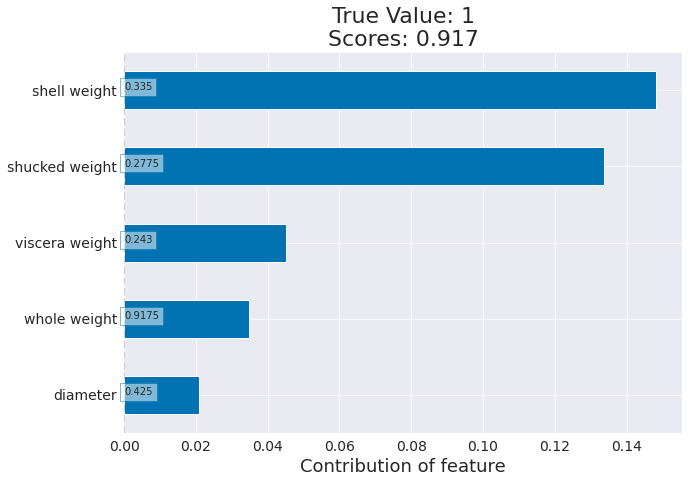

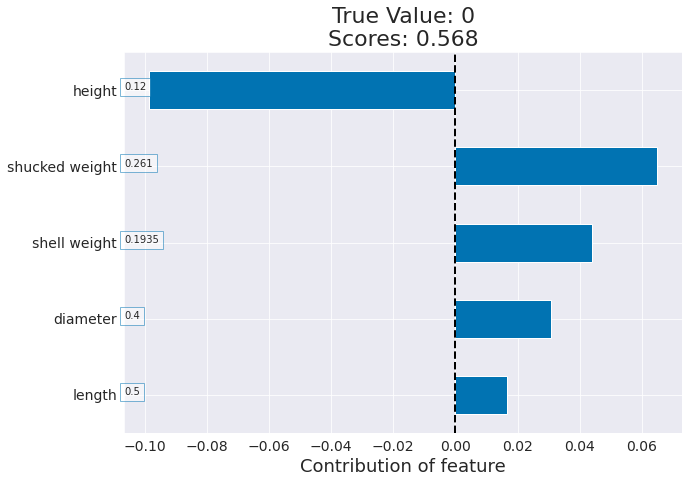

In [107]:
# plot_obs_feature_contrib(模型,贡献值,X_test,y_test,)
print("hz- np.shape(rf_bin_clf_contrib_: " + str(np.shape(rf_bin_clf_contrib)) )  # (836, 7, 2)
print("hz- np.shape(X_test): " + str( np.shape(X_test) )) # (836, 7)
print("hz- np.shape(y_test_bin_clf): " + str( np.shape(y_test_bin_clf)) ) # (836,)

print("hz- rf_bin_clf_contrib: " + str(rf_bin_clf_contrib)) 
print("hz- X_test: " + str(X_test)) # 
print("hz- y_test_bin_clf: " + str(y_test_bin_clf))
for i in range(2): #hz-
    df, labels, pred = plot_obs_feature_contrib(rf_bin_clf,
                                                rf_bin_clf_contrib,
                                                X_test,
                                                y_test_bin_clf,
                                                i,
                                                class_index=1,
                                                num_features=5,
                                                order_by='contribution'
                                               )

Note that the function also returns a DataFrame of the contributions, labels, and predictions in a tuple

In [108]:
display(df)
print('Label: {}'.format(labels))
print('Predicted probabilities: {}'.format(pred))

,feat_val,contrib,abs_contrib
whole weight,0.6160,-0.004782,0.004782
viscera weight,0.1430,0.012388,0.012388
length,0.5000,0.016451,0.016451
diameter,0.4000,0.030889,0.030889
shell weight,0.1935,0.044070,0.044070
shucked weight,0.2610,0.064756,0.064756
height,0.1200,-0.098451,0.098451


Label: 0
Predicted probabilities: [0.432, 0.568]


We may also order them by their natural ordering, i.e., how they appear in the table. This will allow us to compare directly between observations.

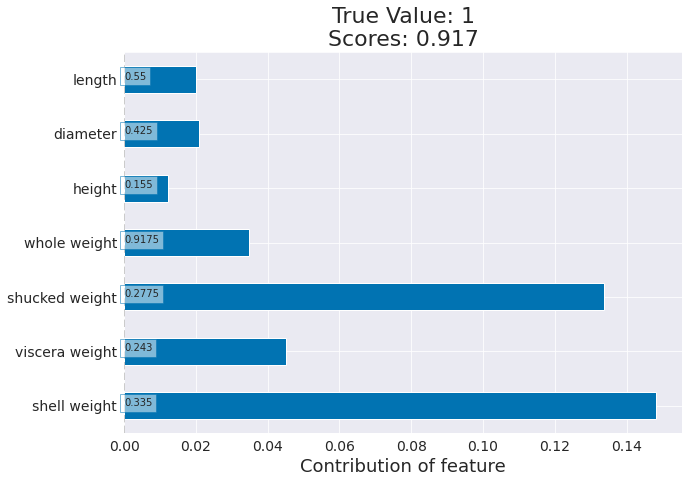

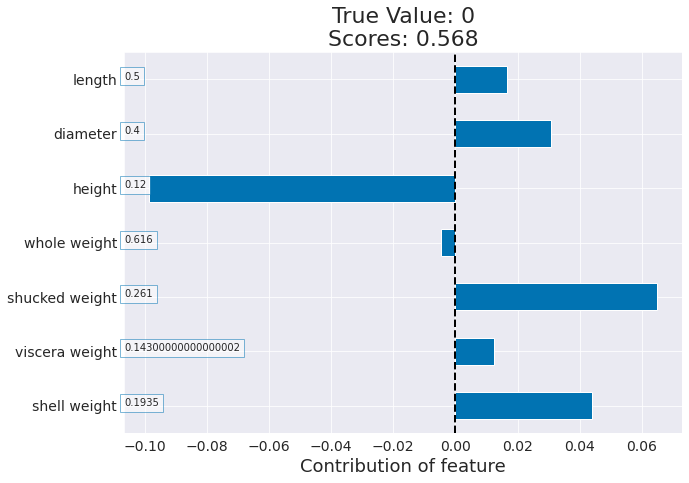

In [109]:
for i in range(2):
    df, labels, pred = plot_obs_feature_contrib(rf_bin_clf,
                                                rf_bin_clf_contrib,
                                                X_test,
                                                y_test_bin_clf,
                                                i,
                                                class_index=1,
                                                order_by='natural'
                                               )

We can also plot them against the contributions of all observations by using violin plots. This will show the given observation's contributions against the entire population's.

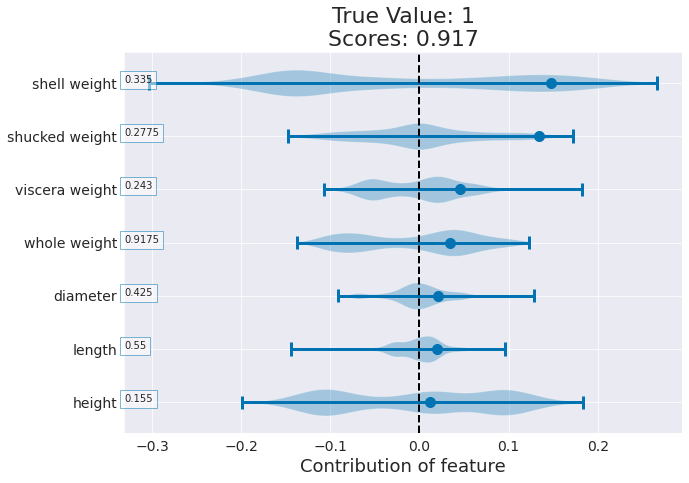

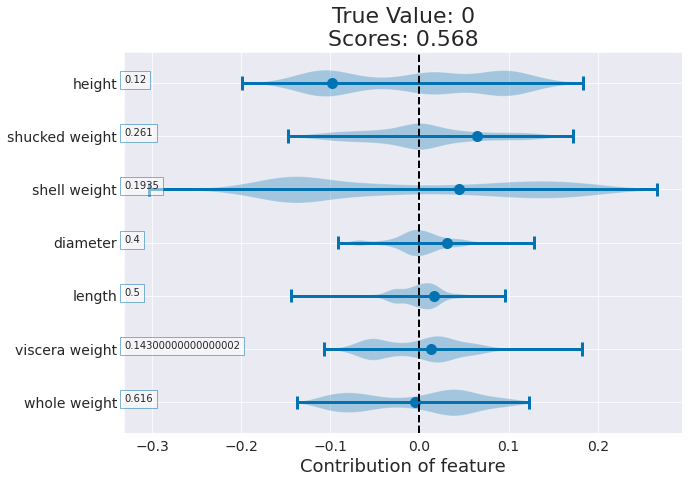

In [110]:
for i in range(2):
    df, labels, pred = plot_obs_feature_contrib(rf_bin_clf,
                                                rf_bin_clf_contrib,
                                                X_test,
                                                y_test_bin_clf,
                                                i,
                                                class_index=1,
                                                order_by='contribution',
                                                violin=True
                                               )

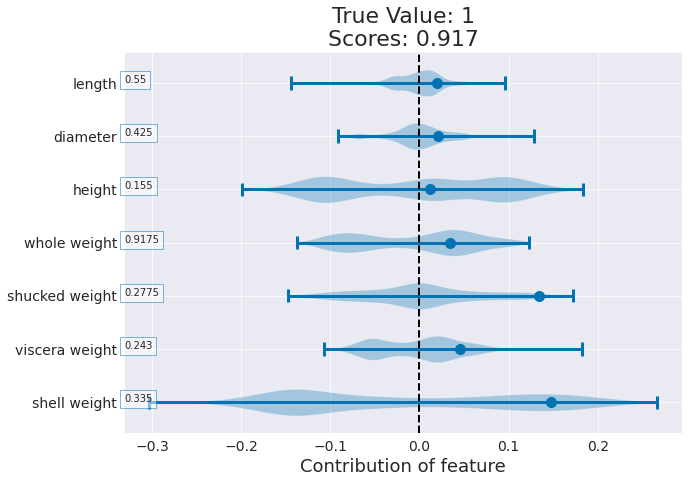

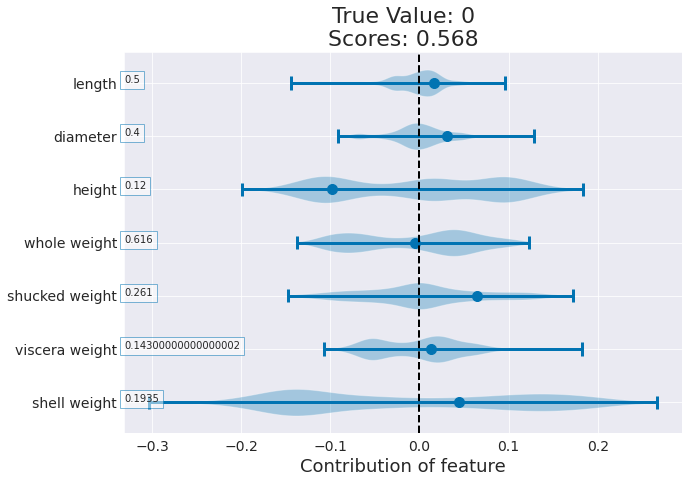

In [111]:
for i in range(2):
    df, labels, pred = plot_obs_feature_contrib(rf_bin_clf,
                                                rf_bin_clf_contrib,
                                                X_test,
                                                y_test_bin_clf,
                                                i,
                                                class_index=1,
                                                order_by='natural',
                                                violin=True
                                               )

# Plotting Individual Features
We now plot individual feature values against their contribution. This should give us some pattern on how each feature affects the contribution of that feature in the model.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


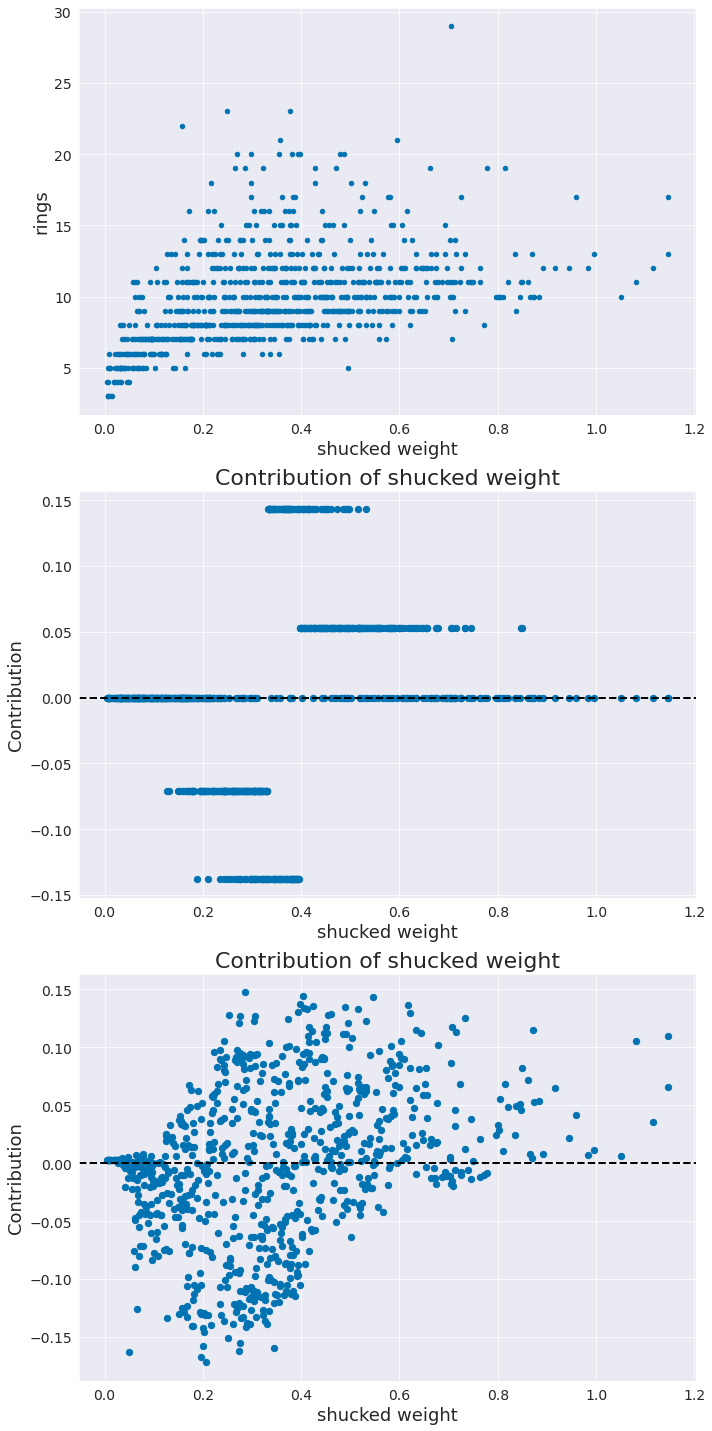

In [112]:
col_name = 'shucked weight'

fig, ax = plt.subplots(3, 1)
fig.set_figheight(20)
abalone_test[[col_name, 'rings']].plot(x=col_name, y='rings',
                                       kind='scatter', ax=ax[0])
plot_single_feat_contrib(col_name, dt_bin_clf_contrib, X_test, ax=ax[1])
plot_single_feat_contrib(col_name, rf_bin_clf_contrib, X_test, ax=ax[2])

plt.tight_layout()

The `plot_single_feat_contrib` function is also setup to not need the `ax` object.

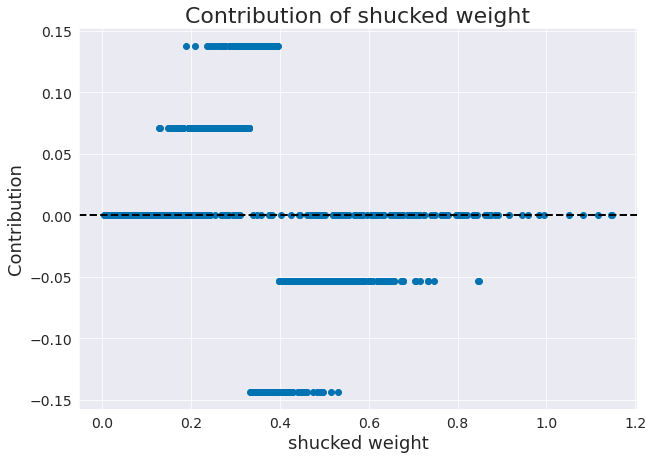

In [113]:
plot_single_feat_contrib(col_name, dt_bin_clf_contrib, X_test,
                         class_index=1)

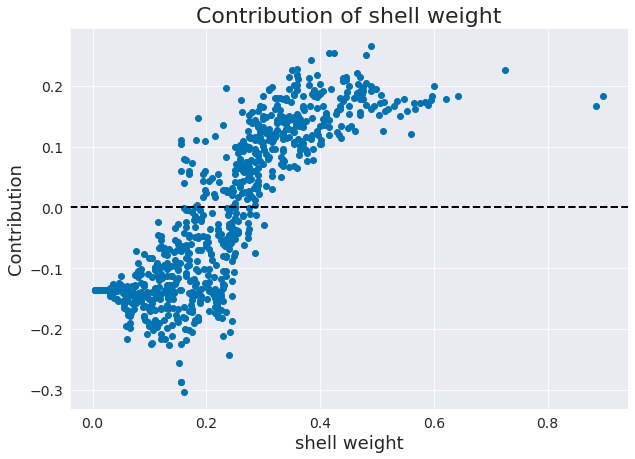

In [114]:
plot_single_feat_contrib('shell weight', rf_bin_clf_contrib, X_test,
                         class_index=1)

We can also add a <a href='http://www.statisticshowto.com/lowess-smoothing/'>LOWESS</a> smoothing curve to the data to see a trend curve by adding the tag `add_smooth=True`.

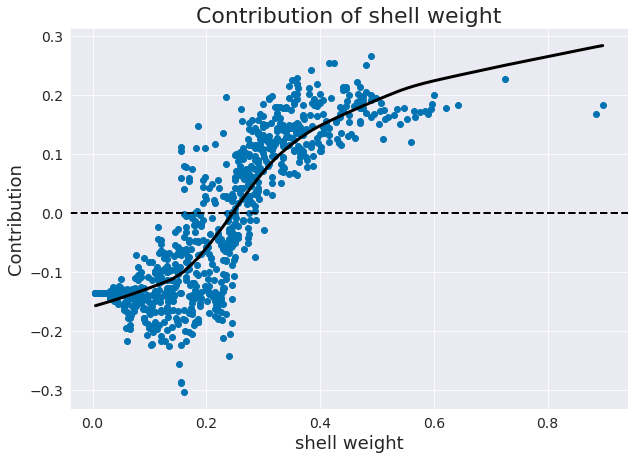

In [115]:
plot_single_feat_contrib('shell weight', rf_bin_clf_contrib, X_test,
                         class_index=1, add_smooth=True)

The LOWESS curve takes in a `frac` parameter, which specifies the fraction of data in a neighbourhood around the point to use to do linear regression. We put the feature in as an option here too.

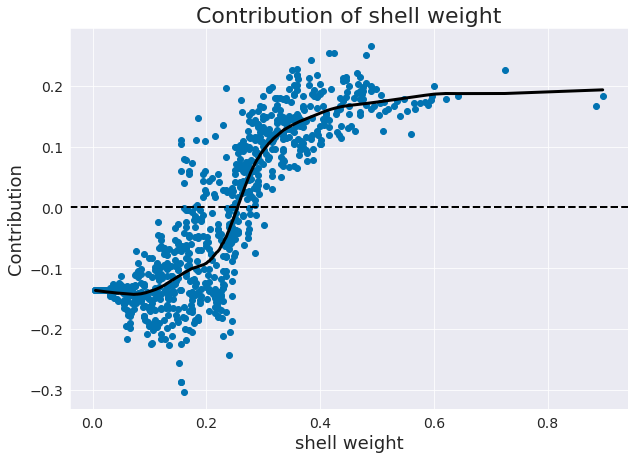

In [116]:
plot_single_feat_contrib('shell weight', rf_bin_clf_contrib, X_test,
                         class_index=1, add_smooth=True, frac=0.3)

In [117]:
colours = [blue, green, red]
class_names = ['Sex = {}'.format(s) for s in ('F', 'M', 'I')]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


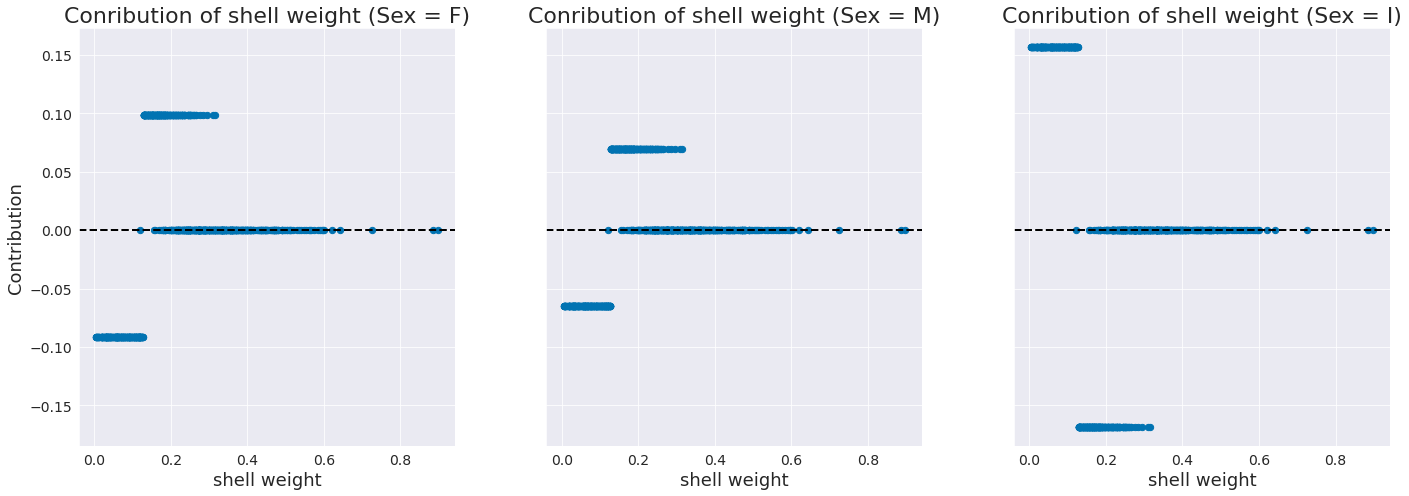

In [118]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(20)

for i in range(3):
    plot_single_feat_contrib('shell weight', dt_multi_clf_contrib, X_test,
                             class_index=i, class_name=class_names[i],
                             c=colours[i], ax=ax[i])
    
plt.tight_layout()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
hz ok


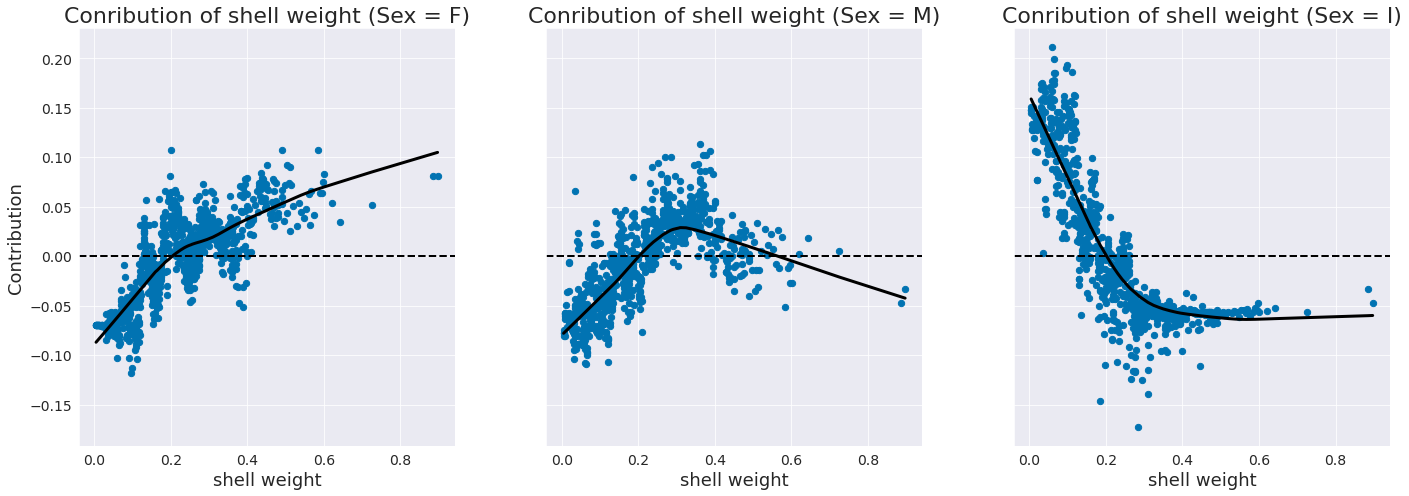

In [119]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(20)

for i in range(3):
    plot_single_feat_contrib('shell weight', rf_multi_clf_contrib, X_test,
                             class_index=i, class_name=class_names[i],
                             add_smooth=True, c=colours[i], ax=ax[i])
    
plt.tight_layout()
print("hz ok")